# Compare CI vs SI runs

This notebook makes manuscript plots comparing the CI vs. SI unstable runs.

1) Figure comparing lateral versus vertical shear production for the two runs.

2) Figure showing two panel vertical profiles of shear production, buoyancy production, and diss (with scaling for eps).


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.special as special
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [22]:
#Function to find convective and low PV layer depth
def findH(q, Qint, wpbp, z):
    #low PV layer
    indq = np.where(q>0.5*Qint)[0][0]
    H = z[indq]

    #convective layer
    #inds = np.where(np.logical_and(np.logical_and(wpbp<0, z<=H), z>10))[0]
    zm = 0.5*(z[1:]+z[0:-1])
    inds = np.where(np.logical_and(np.diff(np.signbit(wpbp)), np.logical_and(zm>1, zm<H*0.5)))[0]
    if inds.size == 0:
        inds = np.where(np.logical_and(np.diff(np.signbit(wpbp)), zm<H))[0]

    if inds.size == 0:
        print('No Ind ' )
        h = H
    else:
        inds = [inds[0]]
        h = z[inds[0]]
    return H, h


In [49]:
def EstimateBStress(f, visc):
    N = f['tasks']['N'][0,0,0] #Interior stratification (background)
    tht = f['tasks']['tht'][0,0,0] # Slope angle
    S2 = N**2*tht**2/1e-8
    
    v = f['tasks']['v'] # Along-slope direction
    z = v.dims[2][0][:]
    time = v.dims[0][0][:]
    vm = np.mean(v, axis=1)
    vz = np.gradient(vm, axis=-1)/np.gradient(z) 
    tauy = -1035*visc*vz[:,0] #Note that 1e-4 is the viscosity for the DNS

    # Calculate the Ekman transport using bottom stress:
    Beka = tauy/(1030*1e-4*(1+S2))*N**2*np.sin(tht)
    
    nt = Beka.shape[0]
    toff = 12
    Ho = 8
    Ent = 1.0 # Entrainment factor...
    H2 = np.zeros((nt, )) 
    for i in range(toff, nt):
        H2[i] = H2[i-1]+(2*(1+S2)*Ent*-Beka[i]/(N**2))*(time[i]-time[i-1])
    
    H = np.sqrt(Ho**2 + H2)
    H[0:toff] = np.nan
    
    qm = f['tasks']['PV']
    qm = np.mean(qm, axis=1)
    return H, Beka, S2, N, qm


def CalcWProdTerms(f):
    u = f['tasks']['u']
    w = f['tasks']['w']
    z = u.dims[2][0][:]

    up = u - np.mean(u, axis=1)[:,np.newaxis,:]
    tht = f['tasks']['tht'][0,0,0] # Slope angle
    
    # calculate all necessary prime terms
    uc = u*np.cos(tht) - w*np.sin(tht)
    upc = uc - np.mean(uc, axis=1)[:,np.newaxis,:]
    wpc = w*np.cos(tht) + up*np.sin(tht)
    upcwpc = np.mean(upc*wpc, axis=1)
    wpcwpc = np.mean(wpc*wpc, axis=1)
    ucm = np.mean(uc, axis=1)

    # calculate all necessary derivative terms
    wcm = ucm*np.sin(tht)/np.cos(tht) # CONSIDER IF THIS IS THE ONLY/BEST WAY TO DO THIS
    wcm_z = np.gradient(wcm, axis=-1)/np.gradient(z)
    wcm_xhat = -wcm_z*np.sin(tht)
    wcm_zhat = wcm_z*np.cos(tht)


    # calculate W terms
    wvsp = - wpcwpc*wcm_zhat
    wlsp = - upcwpc*wcm_xhat
    
    return wvsp, wlsp

In [51]:
#%% Pick the filename and path
CIfilename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05_LONG.h5' #0.1 slope
#CIfilename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p1/snapshots/snapshots_1e-5_0p1_MS.h5' #0.1 slope

SIfilename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LNG.h5' #Ruan case F

visc = 1e-4
Vi = 0.1

SAVEFLAG = False # Turn on to savefigs


f = h5py.File(CIfilename, 'r')
LATSP_CI = -f['tasks']['LSPv'][:,0,:] - f['tasks']['LSPu'][:,0,:]
VERTSP_CI = -f['tasks']['VSPv'][:,0,:] - f['tasks']['VSPu'][:,0,:]
SP_CI = -f['tasks']['SP'][:,0,:]
DISS_CI  = f['tasks']['Diss'][:,0,:]
VBP_CI = f['tasks']['VBFr'][:,0,:]
VBPROT_CI = f['tasks']['VBFrotated'][:,0,:]
ws = f['tasks']['ws']
bs = f['tasks']['bs']
vbfs = 2*np.real(np.conj(ws)*bs)
kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction
kcut = np.where(kx<1e-2)[0]
kcut = kcut[-1]
VBFH_CI = np.sum(vbfs[:,kcut:,:], axis=1)
H_CI, BEK_CI, S2_CI, N_CI, QM_CI = EstimateBStress(f, visc)
wvsp_CI, wlsp_CI = CalcWProdTerms(f)
# Domain parameters
z_CI = f['tasks']['u'].dims[2][0][:]
time_CI = f['tasks']['u'].dims[0][0][:]

##### SI RUN  ########
f = h5py.File(SIfilename, 'r')
LATSP_SI = -f['tasks']['LSPv'][:,0,:] - f['tasks']['LSPu'][:,0,:]
VERTSP_SI = -f['tasks']['VSPv'][:,0,:] - f['tasks']['VSPu'][:,0,:]
SP_SI = -f['tasks']['SP'][:,0,:]
DISS_SI  = f['tasks']['Diss'][:,0,:]
VBP_SI = f['tasks']['VBFr'][:,0,:]
VBPROT_SI = f['tasks']['VBFrotated'][:,0,:]
ws = f['tasks']['ws']
bs = f['tasks']['bs']
vbfs = 2*np.real(np.conj(ws)*bs)
kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction
kcut = np.where(kx<1e-2)[0]
kcut = kcut[-1]
VBFH_SI = np.sum(vbfs[:,kcut:,:], axis=1)
H_SI, BEK_SI, S2_SI, N_SI, QM_SI = EstimateBStress(f, visc)
wvsp_SI, wlsp_SI = CalcWProdTerms(f)

# Domain parameters
z_SI = f['tasks']['u'].dims[2][0][:]
time_SI = f['tasks']['u'].dims[0][0][:]



In [54]:
LATSP_SI_T = LATSP_SI + wlsp_SI
VERTSP_SI_T = VERTSP_SI + wvsp_SI
LATSP_CI_T = LATSP_CI + wlsp_CI
VERTSP_CI_T = VERTSP_CI + wvsp_CI

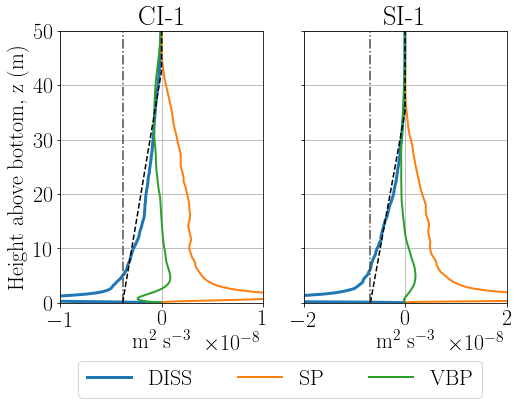

In [5]:
t1 = 4
t2 = 6
#t1 = 11
#t2 = 13
ti_CI = np.where((time_CI/86400>t1) & (time_CI/86400<t2))[0] # Pick the time range to average over
ti_SI = np.where((time_SI/86400>t1) & (time_SI/86400<t2))[0] # Pick the time range to average over

fig, ax = plt.subplots(1,2,sharey=True, figsize=(8,5))
ax[0].plot(np.mean(DISS_CI[ti_CI,:], axis=0), z_CI, linewidth=3)
ax[0].plot(np.mean(SP_CI[ti_CI,:], axis=0), z_CI, linewidth=2)
ax[0].plot(np.mean(VBP_CI[ti_CI,:], axis=0), z_CI, linewidth=2)
ax[0].axvline(np.mean(BEK_CI[ti_CI]), color='0.3', linestyle='-.')
#ax[0].axhline(np.mean(H_CI[ti_CI]))
ax[0].grid()
PEPS = np.mean(BEK_CI[ti_CI])*(1-z_CI/np.mean(H_CI[ti_CI]))
PEPS[z_CI>np.mean(H_CI[ti_CI])] = 0
ax[0].plot(PEPS, z_CI, color='k', linestyle='--')
ax[0].set_ylim(0, 50)
ax[0].set_xlim(-1e-8, 1e-8)
ax[0].set_title('CI-1')
ax[0].set_xlabel('m$^2$ s$^{-3}$')

### SI ####
l1 = ax[1].plot(np.mean(DISS_SI[ti_SI,:], axis=0), z_SI, linewidth=3, label='DISS')
l2 = ax[1].plot(np.mean(SP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='SP')
ax[1].plot(np.mean(VBP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='VBP')
ax[1].axvline(np.mean(BEK_SI[ti_SI]), color='0.3', linestyle='-.')
#ax[0].axhline(np.mean(H_CI[ti_CI]))
ax[1].grid()
PEPS = np.mean(BEK_SI[ti_SI])*(1-z_SI/np.mean(H_SI[ti_SI]))
PEPS[z_SI>np.mean(H_SI[ti_SI])] = 0
ax[1].plot(PEPS, z_SI, color='k', linestyle='--')
ax[1].set_xlim(-2e-8, 2e-8)
ax[1].set_title('SI-1')
ax[1].set_xlabel('m$^2$ s$^{-3}$')

ax[1].legend(bbox_to_anchor=(-0.115, -0.35), loc='lower center', borderaxespad=0., ncol=3)
ax[0].set_ylabel('Height above bottom, z (m)')

#SAVEFLAG = True
if SAVEFLAG:
    plt.savefig(f'./MSFigs/DISSProfiles.pdf', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

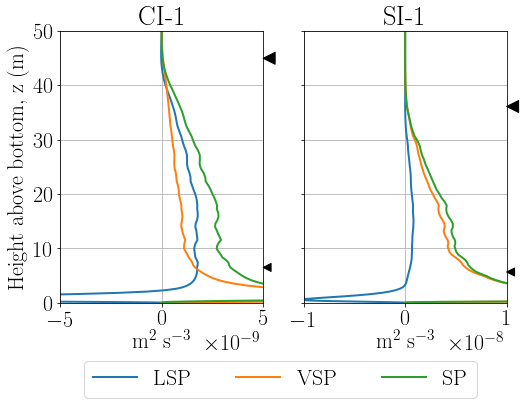

In [60]:
# MODIFIED WITH LSP + VSP + W TERMS
t1 = 11
t2 = 13
t1 = 4
t2 = 6

#t1 = 25
#t2 = 30
ti_CI = np.where((time_CI/86400>t1) & (time_CI/86400<t2))[0] # Pick the time range to average over
ti_SI = np.where((time_SI/86400>t1) & (time_SI/86400<t2))[0] # Pick the time range to average over

plt.figure()
fig, ax = plt.subplots(1,2,sharey=True, figsize=(8,5))
ax[0].plot(np.mean(LATSP_CI_T[ti_CI,:], axis=0), z_CI, linewidth=2)
ax[0].plot(np.mean(VERTSP_CI_T[ti_CI,:], axis=0), z_CI, linewidth=2)
ax[0].plot(np.mean(VERTSP_CI_T[ti_CI,:] + LATSP_CI_T[ti_CI,:], axis=0), z_CI, linewidth=2)
#ax[0].plot(np.mean(SP_CI[ti_CI,:], axis=0), z_SI, linewidth=2, label='SP-DIR')
ax[0].grid()
ax[0].set_xlim(-5e-9, 5e-9)
#ax[0].set_xlim(-1e-9, 1e-9)

ax[0].set_title('CI-1')
ax[0].set_xlabel('m$^2$ s$^{-3}$')

ax[1].plot(np.mean(LATSP_SI_T[ti_SI,:], axis=0), z_SI, linewidth=2, label='LSP')
ax[1].plot(np.mean(VERTSP_SI_T[ti_SI,:], axis=0), z_SI, linewidth=2, label='VSP')
ax[1].plot(np.mean(VERTSP_SI_T[ti_SI,:] + LATSP_SI_T[ti_SI,:], axis=0), z_SI, linewidth=2, label='SP')
#ax[1].plot(np.mean(SP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='SP-DIR')

ax[1].set_xlim(-1e-8, 1e-8)
ax[1].grid()
ax[1].set_title('SI-1')
ax[1].set_xlabel('m$^2$ s$^{-3}$')
ax[0].set_ylim(0, 50)
ax[0].set_ylabel('Height above bottom, z (m)')

ax[1].legend(bbox_to_anchor=(-0.115, -0.35), loc='lower center', borderaxespad=0., ncol=3)


Hnum, hnum = findH(np.mean(QM_CI[ti_CI,:],axis=0), 1e-4*N_CI**2, np.mean(VBFH_CI[ti_CI,:], axis=0) , z_CI)
#ax[0].plot(5e-9, hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax[0].plot(5e-9, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax[0].annotate('', xy=(5e-9, Hnum), xytext=(5.05e-9, Hnum),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax[0].annotate('', xy=(5e-9, hnum), xytext=(5.05e-9, hnum),
            arrowprops=dict(facecolor='black', headwidth=8, headlength=8),
            )
Hnum, hnum = findH(np.mean(QM_SI[ti_CI,:],axis=0), 1e-4*N_SI**2, np.mean(VBFH_SI[ti_SI,:], axis=0) , z_SI)
#ax[1].plot(10e-9, hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax[1].plot(10e-9, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax[1].annotate('', xy=(10.0e-9, Hnum), xytext=(10.05e-9, Hnum),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax[1].annotate('', xy=(10e-9, hnum), xytext=(10.05e-9, hnum),
            arrowprops=dict(facecolor='black', headwidth=8, headlength=8),
            )
SAVEFLAG = False
if SAVEFLAG:
    plt.savefig(f'./MSFigs/LSPvVSP.pdf', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

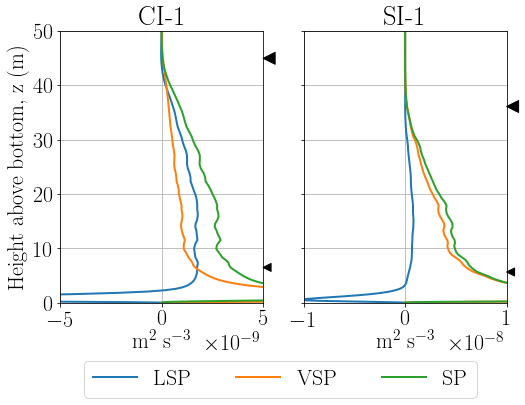

In [45]:
# ORIGINAL WITH LSP + VSP
t1 = 11
t2 = 13
t1 = 4
t2 = 6

#t1 = 25
#t2 = 30
ti_CI = np.where((time_CI/86400>t1) & (time_CI/86400<t2))[0] # Pick the time range to average over
ti_SI = np.where((time_SI/86400>t1) & (time_SI/86400<t2))[0] # Pick the time range to average over

plt.figure()
fig, ax = plt.subplots(1,2,sharey=True, figsize=(8,5))
ax[0].plot(np.mean(LATSP_CI[ti_CI,:], axis=0), z_CI, linewidth=2)
ax[0].plot(np.mean(VERTSP_CI[ti_CI,:], axis=0), z_CI, linewidth=2)
ax[0].plot(np.mean(VERTSP_CI[ti_CI,:] + LATSP_CI[ti_CI,:], axis=0), z_CI, linewidth=2)
#ax[0].plot(np.mean(SP_CI[ti_CI,:], axis=0), z_CI) #sanity check that total shear production equals LSP + VSP
ax[0].grid()
ax[0].set_xlim(-5e-9, 5e-9)
#ax[0].set_xlim(-1e-9, 1e-9)

ax[0].set_title('CI-1')
ax[0].set_xlabel('m$^2$ s$^{-3}$')

ax[1].plot(np.mean(LATSP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='LSP')
ax[1].plot(np.mean(VERTSP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='VSP')
ax[1].plot(np.mean(VERTSP_SI[ti_SI,:] + LATSP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='SP')
ax[1].set_xlim(-1e-8, 1e-8)
ax[1].grid()
ax[1].set_title('SI-1')
ax[1].set_xlabel('m$^2$ s$^{-3}$')
ax[0].set_ylim(0, 50)
ax[0].set_ylabel('Height above bottom, z (m)')

ax[1].legend(bbox_to_anchor=(-0.115, -0.35), loc='lower center', borderaxespad=0., ncol=3)


Hnum, hnum = findH(np.mean(QM_CI[ti_CI,:],axis=0), 1e-4*N_CI**2, np.mean(VBFH_CI[ti_CI,:], axis=0) , z_CI)
#ax[0].plot(5e-9, hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax[0].plot(5e-9, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax[0].annotate('', xy=(5e-9, Hnum), xytext=(5.05e-9, Hnum),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax[0].annotate('', xy=(5e-9, hnum), xytext=(5.05e-9, hnum),
            arrowprops=dict(facecolor='black', headwidth=8, headlength=8),
            )
Hnum, hnum = findH(np.mean(QM_SI[ti_CI,:],axis=0), 1e-4*N_SI**2, np.mean(VBFH_SI[ti_SI,:], axis=0) , z_SI)
#ax[1].plot(10e-9, hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax[1].plot(10e-9, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax[1].annotate('', xy=(10.0e-9, Hnum), xytext=(10.05e-9, Hnum),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax[1].annotate('', xy=(10e-9, hnum), xytext=(10.05e-9, hnum),
            arrowprops=dict(facecolor='black', headwidth=8, headlength=8),
            )
SAVEFLAG = False
if SAVEFLAG:
    plt.savefig(f'./MSFigs/LSPvVSP.pdf', bbox_inches='tight')

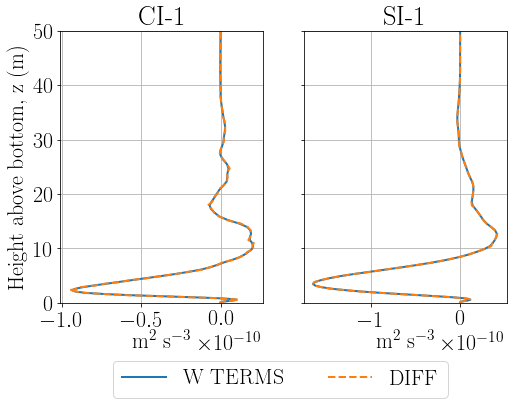

In [71]:
# COMPARE DIFFS
t1 = 11
t2 = 13
t1 = 4
t2 = 6

#t1 = 25
#t2 = 30
ti_CI = np.where((time_CI/86400>t1) & (time_CI/86400<t2))[0] # Pick the time range to average over
ti_SI = np.where((time_SI/86400>t1) & (time_SI/86400<t2))[0] # Pick the time range to average over

fig, ax = plt.subplots(1,2,sharey=True, figsize=(8,5))
ax[0].plot(np.mean(wvsp_CI[ti_CI,:]+wlsp_CI[ti_CI,:], axis=0), z_CI, linewidth=2)
#ax[0].plot(np.mean(VERTSP_CI[ti_CI,:], axis=0), z_CI, linewidth=2)
ax[0].plot(np.mean(SP_CI[ti_CI,:] - VERTSP_CI[ti_CI,:] - LATSP_CI[ti_CI,:], axis=0), z_CI, linewidth=2, linestyle='--')
#ax[0].plot(np.mean(SP_CI[ti_CI,:], axis=0), z_CI) #sanity check that total shear production equals LSP + VSP
ax[0].grid()
#ax[0].set_xlim(-5e-9, 5e-9)
#ax[0].set_xlim(-1e-9, 1e-9)

ax[0].set_title('CI-1')
ax[0].set_xlabel('m$^2$ s$^{-3}$')

ax[1].plot(np.mean(wvsp_SI[ti_SI,:]+wlsp_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='W TERMS')
#ax[1].plot(np.mean(VERTSP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, label='VSP')
ax[1].plot(np.mean(SP_SI[ti_SI,:] - VERTSP_SI[ti_SI,:] - LATSP_SI[ti_SI,:], axis=0), z_SI, linewidth=2, linestyle='--',label='DIFF')
#ax[1].set_xlim(-1e-8, 1e-8)
ax[1].grid()
ax[1].set_title('SI-1')
ax[1].set_xlabel('m$^2$ s$^{-3}$')
ax[0].set_ylim(0, 50)
ax[0].set_ylabel('Height above bottom, z (m)')

ax[1].legend(bbox_to_anchor=(-0.115, -0.35), loc='lower center', borderaxespad=0., ncol=3)


Hnum, hnum = findH(np.mean(QM_CI[ti_CI,:],axis=0), 1e-4*N_CI**2, np.mean(VBFH_CI[ti_CI,:], axis=0) , z_CI)
#ax[0].plot(5e-9, hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax[0].plot(5e-9, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
#ax[0].annotate('', xy=(5e-9, Hnum), xytext=(5.05e-9, Hnum),
#            arrowprops=dict(facecolor='black', shrink=0.05),
#            )
#ax[0].annotate('', xy=(5e-9, hnum), xytext=(5.05e-9, hnum),
#            arrowprops=dict(facecolor='black', headwidth=8, headlength=8),
#            )
Hnum, hnum = findH(np.mean(QM_SI[ti_CI,:],axis=0), 1e-4*N_SI**2, np.mean(VBFH_SI[ti_SI,:], axis=0) , z_SI)
#ax[1].plot(10e-9, hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax[1].plot(10e-9, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
#ax[1].annotate('', xy=(10.0e-9, Hnum), xytext=(10.05e-9, Hnum),
#            arrowprops=dict(facecolor='black', shrink=0.05),
#            )
#ax[1].annotate('', xy=(10e-9, hnum), xytext=(10.05e-9, hnum),
#            arrowprops=dict(facecolor='black', headwidth=8, headlength=8),
#            )
SAVEFLAG = False
if SAVEFLAG:
    plt.savefig(f'./MSFigs/LSPvVSPDIFF.pdf', bbox_inches='tight')

In [7]:
## Look at the verticaly integrated LSP vs. VSP ratio compared to S^2

zlower = 10
zl = np.argmin(np.abs(z_CI-zlower))
LATSP_CI_I = integrate.trapz(np.mean(LATSP_CI[ti_CI,zl:], axis=0), x=z_CI[zl:])
VERTSP_CI_I = integrate.trapz(np.mean(VERTSP_CI[ti_CI,zl:], axis=0), x=z_CI[zl:])

print(LATSP_CI_I)
print(VERTSP_CI_I)
print(LATSP_CI_I/VERTSP_CI_I)

zl = np.argmin(np.abs(z_SI-zlower))
LATSP_SI_I = integrate.trapz(np.mean(LATSP_SI[ti_SI,zl:], axis=0), x=z_SI[zl:])
VERTSP_SI_I = integrate.trapz(np.mean(VERTSP_SI[ti_SI,zl:], axis=0), x=z_SI[zl:])

print(LATSP_SI_I)
print(VERTSP_SI_I)
print(LATSP_SI_I/VERTSP_SI_I)

7.928532016333698e-09
1.051234646531617e-09
7.542114448465563
5.6657969143322415e-09
2.090791069176182e-08
0.27098819187919576


In [8]:
f['tasks']['LSPu'][:,0,:]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.04807588e-18,  5.90503086e-17,  3.64587433e-16, ...,
        -3.38469235e-21,  2.00965020e-21, -6.41151141e-22],
       [ 2.05699663e-19,  6.21766460e-17,  3.68641978e-16, ...,
         1.39180147e-21, -8.37640485e-22,  2.88527537e-22],
       ...,
       [ 1.14286777e-14,  9.83898906e-13,  6.85962763e-12, ...,
         6.71544806e-17, -3.48469695e-17, -6.40313412e-18],
       [ 1.23503133e-14,  9.40256825e-13,  6.58071161e-12, ...,
        -2.30584574e-17,  1.38940738e-17, -4.93355363e-18],
       [ 1.14511587e-14,  9.04657635e-13,  6.32660497e-12, ...,
         1.00950711e-16, -5.36030212e-17, -1.54820681e-17]])